In [2]:
import pandas as pd
import numpy as np
import glob
import os
import numpy as np
from pathlib import Path
from shutil import copyfile
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
datapath = '../data/'

# Pilot dataset

This dataset includes all the images that were digitized as part of the NWO-KIEM pilot

In [7]:
pilot = pd.read_excel(datapath + 'external/DeBoer_pilot.xlsx')
pilot = pilot.dropna(how='all', subset=['Catalogus-kaart']) # drop values that have no catalogue-info
pilot['Invoernummer_Onderwerpskaarten'] = pd.to_numeric(pilot['Invoernummer_Onderwerpskaarten'], downcast='integer')

In [8]:
print('Totaal Cataloguskaart 1: {}'.format(pilot['Catalogus-kaart'].count()))
print('Totaal Cataloguskaart 2: {}'.format(pilot['Catalogus-kaart 2'].count()))
print('Totaal Cataloguskaart 3: {}'.format(pilot['Catalogus-kaart 3'].count()))
print('Totaal Cataloguskaart 4: {}'.format(pilot['Catalogus-kaart 4'].count()))


Totaal Cataloguskaart 1: 2531
Totaal Cataloguskaart 2: 396
Totaal Cataloguskaart 3: 16
Totaal Cataloguskaart 4: 1


In [9]:
pilot = pilot[['Invoernummer_Onderwerpskaarten', 'Catalogus-kaart']]

In [10]:
pilot = pilot.groupby('Catalogus-kaart').head(1)

## Number of subjects

This file contains an overview of all the subjects and the number index cards related to it

In [11]:
n_subjects = pd.read_excel(datapath + 'external/Onderwerpskaarten_totals.xlsx')
n_subjects = n_subjects.iloc[0:1575,] # remove superfluous lines

In [12]:
print('Number of unique subjects: {}'.format(n_subjects['Onderwerpen'].nunique()))

Number of unique subjects: 1574


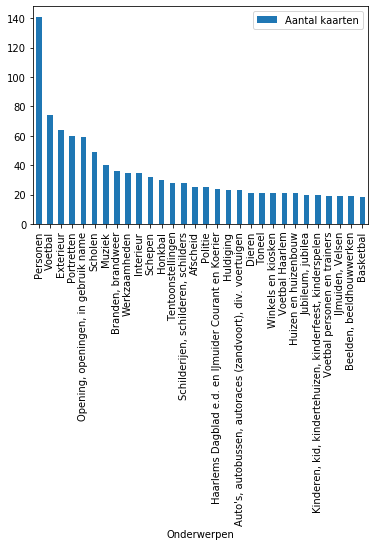

In [13]:
n_subjects.sort_values('Aantal kaarten', ascending=False).head(30).plot.bar(x='Onderwerpen', y='Aantal kaarten')

In [14]:
n_subjects = n_subjects[['Onderwerpen', 'Aantal kaarten', 'Beginjaar', 'Eindjaar']]

## Subject Cards

This dataset contains information on the images for the total set. 

In [15]:
subject_cards = pd.read_excel(datapath + 'external/onderwerpskaarten_1945-1990.xlsx')

In [16]:
print('Number of unique subjects: {}'.format(subject_cards['Catalogus-kaart'].nunique()))

Number of unique subjects: 1408


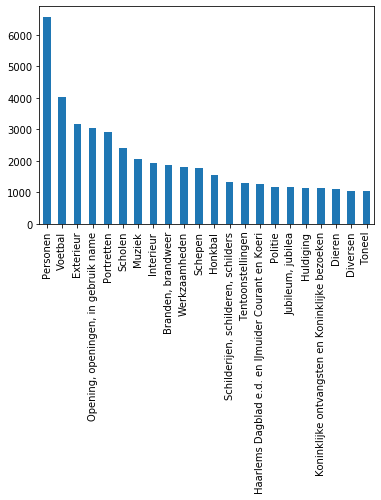

In [17]:
c_ = subject_cards['Catalogus-kaart'].value_counts()
threshold = 1000
mask = c_ > threshold
c_ = c_.loc[mask]
#c_['other'] = tail_c_
c_.plot(kind='bar')
#plt.xticks(rotation=25)
plt.show()

In [18]:
subject_cards['Deelcollectie'].value_counts()

K      123231
B       17563
G        7303
A        4852
C         888
L         536
AC        487
C         486
AL        124
KC        115
A          40
G          36
B          36
K           2
K           2
A           2
 K          1
Name: Deelcollectie, dtype: int64

In [19]:
subject_cards = subject_cards[['Invoernummer_Onderwerpskaarten', 'Catalogus-kaart', 'Code']]

In [20]:
#df = df.groupby('Catalogus-kaart').head(1)

In [21]:
#df[df['Deelcollectie'] == 'G']

# Image Pairing 
Volunteers at NHA are pairing images with subject cards. <br />
Here I check which images have already been paired and which subjects have been paired

In [22]:
drop_vals = ['geen beschrijving aanwezig',
             'ik weet het niet',
             'geen match gevonden'
            ]


processed_photos = []
subjects = []

for file in glob.glob(datapath + 'external/*.xlsx'):
    if (file.split('/')[3].startswith('Uitsnedes')):
        temp = pd.read_excel(file)
        temp = temp[~temp['Invoernummer_Onderwerpskaarten'].isin(drop_vals)]
        temp = temp.dropna(how='all', subset=['Invoernummer_Onderwerpskaarten'])
        processed_photos += temp['Bestand'].to_list()
        subjects += temp['Invoernummer_Onderwerpskaarten'].to_list()
subjects = list(set(subjects))


In [23]:
print('processed {} images'.format(len(processed_photos)))

processed 21643 images


In [24]:
# copy processed images to new folder
small = glob.glob(datapath + 'raw/kleinbeeld/**/*.jpg')

output_path = datapath + 'raw/kleinbeeld_processed'
for file in small:
    if file.split('/')[5] in processed_photos:
        filename = os.path.basename(file)
        copyfile(file, os.path.join(output_path, filename))       

## Images

In [25]:
# glass negatives
g_ = glob.glob(datapath + 'raw/g_/*.jpg')
g_ = [x for x in g_ if x.split('/')[4].startswith('NL-')] # only select ones with code
g_files = [Path(x).stem for x in g_]
g_short = [g[:20] for g in g_files] # for some codes there are multiple images, select base code

In [26]:
# small images
small_processed = glob.glob(datapath + 'raw/kleinbeeld_processed/*.jpg')

## Create Subject files

In [27]:
subject_merge = pd.merge(subject_cards, n_subjects, left_on='Catalogus-kaart', right_on='Onderwerpen')
subject_merge = subject_merge.dropna(how='all', subset=['Catalogus-kaart'])
subject_merge.drop('Onderwerpen', axis=1, inplace=True)

In [28]:
exists = []
for _, row in subject_merge.iterrows():
    if row['Code'][:20] in g_short:
        exists.append('found')
    else:
        exists.append('not_found')
subject_merge['exists'] = exists

In [29]:
for _, row in subject_merge.iterrows():
    if row['Invoernummer_Onderwerpskaarten'] in subjects:
        if row['exists'] == 'not_found':
            row['exists'] == 'found'
        else:
            pass
    else:
        pass

In [30]:
categories = subject_merge.groupby('Catalogus-kaart').head(1)

In [31]:
categories.to_csv('category_cards.csv')

## Prepare Figure Eight

In [576]:
path = 'https://surfdrive.surf.nl/files/remote.php/webdav/boer/'

image_urls = [path + urllib.parse.quote(x) + '.jpg' for x in g_files]

In [577]:
file = pd.DataFrame(image_urls, columns=['image_url'])

In [581]:
file.to_csv('test.csv', index=None)

In [628]:
with open("places365.txt") as f:
    places365 = f.read().splitlines() 

In [629]:
places365 = [x.split(' ')[0][3:] for x in places365]

In [681]:
np.savetxt("places365_categories.csv", places365, delimiter=",", fmt='%s')